# Disability at six month follow up

## Aims

Note: data on disability at six month follow up is not missing at random.

Investigating factors that relate to:
* Whether patients have a record of disability at six months
* Patients disability score/change in disability between discharge and follow up

## Set up

In [1]:
# Import packages and functions
from collections import defaultdict
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score, confusion_matrix)

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path,
                                paths.data_filename))
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Descriptive

### Completion (overall)

This section summarises the completion rate for disability scores at each timepoint. As we would anticipate, no-one marked as having died (which we understand to mean they were not discharged following arrival as they died), has a 6-month follow-up. Hence, summaries of completion are repeated, but for individuals who were alive at discharge.

In [4]:
# Find proportion with complete data by team
data['missing_6_month'] = data['disability_6_month'].isnull()


def count_missing(df):
    '''
    Find count and proportion of people missing disability at each timepoint
    df: pandas dataframe
    '''
    # Mark whether disability is present at each timepoint or not
    mrs_missing = (
        df[['prior_disability',
            'discharge_disability',
            'disability_6_month']]
        .isnull()
        .apply(lambda x: x.map({True: 'Missing', False: 'Not missing'})))

    # Count patterns of missing or not between variables
    mrs_complete = (
        mrs_missing
        .value_counts()
        .reset_index(name='count')
        .sort_values(by='disability_6_month', ascending=False))

    # Convert counts to proportions and display results
    mrs_complete['percentage'] = (
        mrs_complete['count'] / mrs_complete['count'].sum())*100
    print('\nCompletion of disability data:')
    display(mrs_complete)
    return (mrs_missing)


def disability_known_death(df):
    '''
    Add columns indicating whether disability at 6 months was known
    (and return dataframe with that column added). Print the relationship
    between death and disability at 6 months (should see no individuals
    who died have follow-up)
    df: pandas dataframe
    '''
    # Add column indicating whether disability at 6 months was known
    df['disability_6_month_known'] = (
        df['missing_6_month']
        .map({True: 'No (missing)', False: 'Yes (present)'}))

    # View relationship between death and 6 month follow up
    print('\nSee no individuals who died had follow-up:')
    display(df
            .groupby('disability_6_month_known')['death']
            .value_counts(dropna=False)
            .reset_index(name='count'))
    return (df)


def count_alive_missing(df, mrs_missing):
    '''
    Find count and proportion of people missing disability at each timepoint
    Focussing only on individuals who were alive at discharge
    '''
    # Add death
    mrs_missing['death'] = df['death']

    # Count proportion missing data
    mrs_complete_alive = (
        mrs_missing[mrs_missing['death'] == 0]
        .value_counts()
        .reset_index(name='count')
        .sort_values(by='disability_6_month', ascending=False))
    mrs_complete_alive['percentage'] = (
        mrs_complete_alive['count'] / mrs_complete_alive['count'].sum())*100
    print('Completion of disability data (for patients alive at discharge):')
    display(mrs_complete_alive)

**Observations:** For patients arriving within 4 hours of known onset who were alive at discharge, 34.5% have data on disability at 6 months, 64.6% are missing it, and 0.9% are missing discharge and 6-month disability.

In [5]:
print('For patients who arrive within four hours of known onset...')
mrs_missing_data = count_missing(data)
data = disability_known_death(data)
count_alive_missing(data, mrs_missing_data)

For patients who arrive within four hours of known onset...

Completion of disability data:


,prior_disability,discharge_disability,disability_6_month,count,percentage
1,Not missing,Not missing,Not missing,39167,28.585087
0,Not missing,Not missing,Missing,96845,70.679979
2,Not missing,Missing,Missing,1007,0.734935



See no individuals who died had follow-up:


,disability_6_month_known,death,count
0,No (missing),0.0,74322
1,No (missing),1.0,23526
2,No (missing),NaN,4
3,Yes (present),0.0,39167


Completion of disability data (for patients alive at discharge):


,prior_disability,discharge_disability,disability_6_month,death,count,percentage
1,Not missing,Not missing,Not missing,0.0,39167,34.511715
0,Not missing,Not missing,Missing,0.0,73320,64.605380
2,Not missing,Missing,Missing,0.0,1002,0.882905


In [6]:
# print('For all patients...')
# mrs_missing_data_full = count_missing(data_full)
# data_full = disability_known_death(data_full)
# count_alive_missing(data_full, mrs_missing_data_full)

### Filter to alive at discharge

In [7]:
# All patients
data_full_alive = data_full[data_full['death'] == 0]
# Patients who arrive within four hours of known onset
data_alive = data[data['death'] == 0]

### Completion (by team, alive at discharge)

There are two aims to this section:
1. **Looking at whether there are differences in proportion followed up between stroke teams.**
2. **Investigating whether death at 6-months is likely to be automatically input or not.** If death is automatically completed (but other disability scores requiring manual input), then we would generally anticipate units with a low proportion followed up to have disproportionately high death rates.

Find proportion of patients who do not have data on disability at 6 months, by stroke team.

count    119.000000
mean       0.640862
std        0.219576
min        0.097710
25%        0.475200
50%        0.636816
75%        0.814704
max        1.000000
Name: missing_6_month, dtype: float64

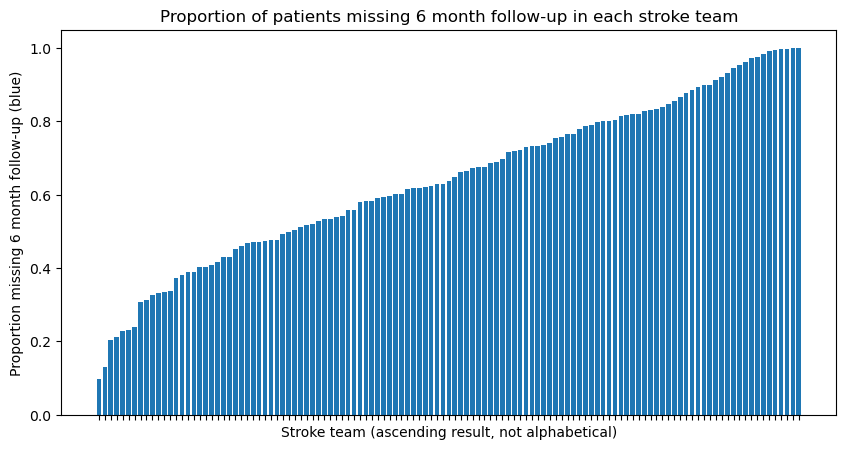

In [8]:
# Find proportion missing follow up in each team
team_missing = (data_alive
                .groupby('stroke_team')['missing_6_month']
                .mean()
                .sort_values())

# Describe the results
display(team_missing.describe())

# Plot completion rate in each team, ascending
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=team_missing.index,
       height=team_missing)
ax.set_xlabel('Stroke team (ascending result, not alphabetical)')
ax.set_ylabel('Proportion missing 6 month follow-up (blue)')
ax.set_title('Proportion of patients missing 6 month follow-' +
             'up in each stroke team')
ax.tick_params(labelbottom=False)
plt.show()

Find number of patients alive at discharge for each team and use that to contextualise the proportion missing follow up

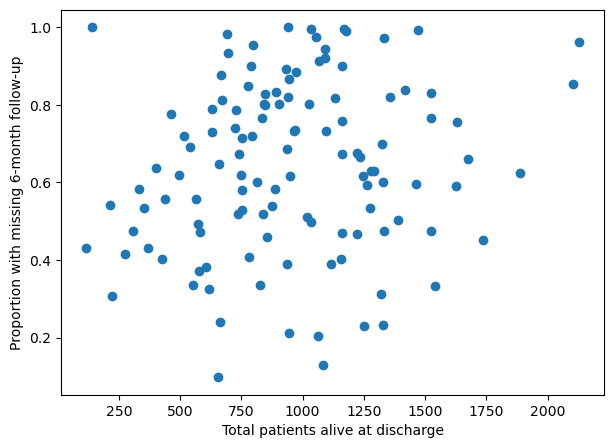

0.15450862362409

In [9]:
team_size = (
    data_alive.groupby('stroke_team').size().rename('alive_at_discharge'))
team_followup_size = pd.concat([team_missing, team_size], axis=1).reset_index()
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x=team_followup_size['alive_at_discharge'],
           y=team_followup_size['missing_6_month'])
ax.set_xlabel('Total patients alive at discharge')
ax.set_ylabel('Proportion with missing 6-month follow-up')
plt.show()

team_followup_size['alive_at_discharge'].corr(
    team_followup_size['missing_6_month'])

<mark>Is case ascertainment more reliable for those who died? Martin: not ONS, entered manually, so will vary between providers, some inputting reliably and some not</mark>

In each stroke team, of those with disability data at 6 months, find the proportion marked as having died.

*There are two teams with no proportion - as there were two teams with no follow ups.*

In [10]:
# Remove patients missing disability at 6 months
complete_6_month = data_alive[['stroke_team', 'disability_6_month']].dropna()

# Create column indicating whether disability was 6 (death) or not
complete_6_month['death'] = complete_6_month['disability_6_month'] == 6

# Find proportion of patients marked as dead at follow up in each team
team_complete_death = complete_6_month.groupby('stroke_team')['death'].mean()
team_complete_death.describe()

count    117.000000
mean       0.107870
std        0.074625
min        0.000000
25%        0.051282
50%        0.090426
75%        0.153061
max        0.500000
Name: death, dtype: float64

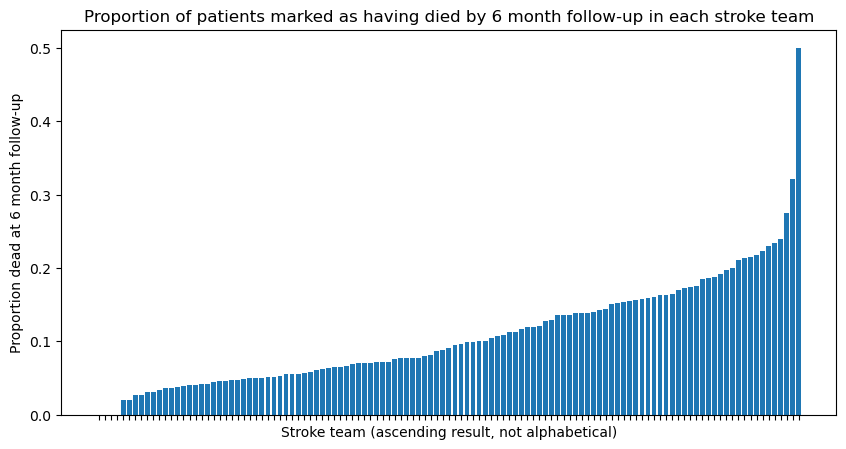

In [11]:
# Plot proportion marked as having died at follow-up in each team, ascending
fig, ax = plt.subplots(figsize=(10, 5))
team_complete_death = team_complete_death.sort_values()
ax.bar(x=team_complete_death.index,
       height=team_complete_death)
ax.set_xlabel('Stroke team (ascending result, not alphabetical)')
ax.set_ylabel('Proportion dead at 6 month follow-up')
ax.set_title('Proportion of patients marked as having died by 6 month ' +
             'follow-up in each stroke team')
ax.tick_params(labelbottom=False)
plt.show()

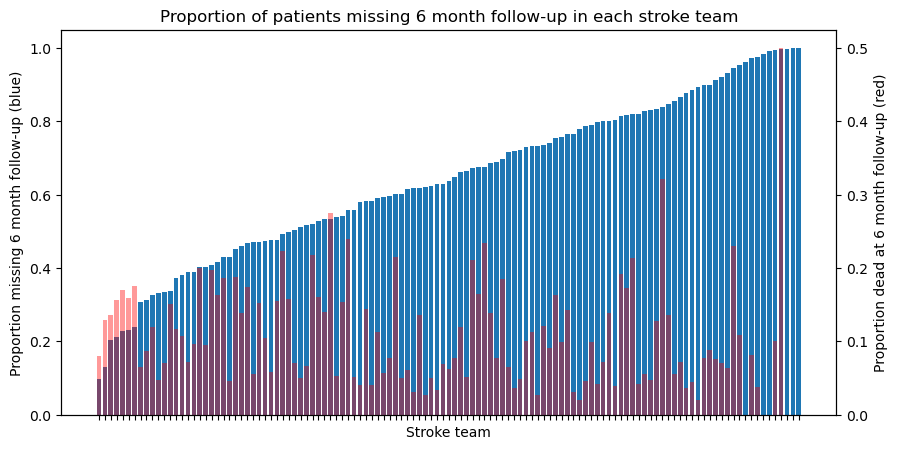

In [12]:
# Add record of the proportion who died
team_missing_death = pd.concat([team_missing,
                                team_complete_death], axis=1).reset_index()

# Plot completion rate in each team, ascending
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x=team_missing_death['stroke_team'],
       height=team_missing_death['missing_6_month'])
ax.set_xlabel('Stroke team')
ax.set_ylabel('Proportion missing 6 month follow-up (blue)')
ax.set_title('Proportion of patients missing 6 month follow-' +
             'up in each stroke team')
ax.tick_params(labelbottom=False)

# Add overlaid histogram with proportion who had died
ax2 = ax.twinx()
ax2.bar(x=team_missing_death['stroke_team'],
        height=team_missing_death['death'],
        color='red', alpha=0.4)
ax2.set_ylabel('Proportion dead at 6 month follow-up (red)')
plt.show()

**Observations:**
* There are large differences between units, in terms of the proportion of patients with complete data for disability at 6-month follow-up. Between teams, this ranges from 9% to 100% with complete data.
* There is not a trend in the proportion dead at 6 months, so it doesn't appear likely that data on death was input automatically

### Comparing patients followed up with those not

**Observations:**

**Stroke severity:** We see a marked difference in stroke severity, but not when only focus on those alive at discharge. In those alive at discharge, we see perhaps a smaller difference than might have anticipated - mean stroke severity 7.04 (not followed up) and 7.00 (followed up).

**Thrombolysed:** Regardless of whether alive at discharge, we see a higher proportion who were thrombolysed have follow-up. This is less so when focus on all patients, and more so when focus on patients who arrived within 4 hours of known stroke onset. For example, in patients arriving within 4 hours of known onset and alive at discharge, 36.2% thrombolysed have follow-up v.s. 33.8% of those not thrombolysed. However, it has been commented that this difference may be smaller than anticipated, based on previous conversations/anecdotes about follow-up.

In [13]:
def compare_follow_up(df):
    '''
    Compare those with follow-up to those not in terms of:
    - Stroke severity
    - Whether they were thrombolysed
    '''
    # Stroke severity
    print('Stroke severity in those followed up v.s. not')
    display(df
            .groupby('disability_6_month_known')['stroke_severity']
            .describe())

    # Thrombolysis
    print('Proportion followed up in those thrombolysed v.s. not')
    display(df
            .groupby('thrombolysis')['disability_6_month_known']
            .value_counts(normalize=True)
            .reset_index(name='proportion'))

In [14]:
print('For patients who arrived within 4 hours of known stroke onset...')
print('All patients (inc. dead at discharge):')
compare_follow_up(data)
print('Patients who were alive at discharge:')
compare_follow_up(data_alive)

For patients who arrived within 4 hours of known stroke onset...
All patients (inc. dead at discharge):
Stroke severity in those followed up v.s. not


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),97852.0,9.689889,8.756325,0.0,3.0,6.0,15.0,42.0
Yes (present),39167.0,6.995940,6.499562,0.0,2.0,5.0,10.0,42.0


Proportion followed up in those thrombolysed v.s. not


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.725331
1,0,Yes (present),0.274669
2,1,No (missing),0.687080
3,1,Yes (present),0.312920


Patients who were alive at discharge:
Stroke severity in those followed up v.s. not


,count,mean,std,min,25%,50%,75%,max
disability_6_month_known,,,,,,,,
No (missing),74322.0,7.040728,6.637187,0.0,2.0,5.0,10.0,42.0
Yes (present),39167.0,6.995940,6.499562,0.0,2.0,5.0,10.0,42.0


Proportion followed up in those thrombolysed v.s. not


,thrombolysis,disability_6_month_known,proportion
0,0,No (missing),0.662091
1,0,Yes (present),0.337909
2,1,No (missing),0.638498
3,1,Yes (present),0.361502


In [15]:
# print('For all patients (including those who were dead at discharge):')
# compare_follow_up(data_full)
# print('For all patients who were alive at discharge:')
# compare_follow_up(data_full_alive)

### Change in disability between discharge and 6-month follow-up

In [16]:
def disability_change(df):
    # Change in mRS score from discharge to 6 months later
    mrs_6m = ((df['disability_6_month'] - df['discharge_disability'])
              .dropna().describe())

    print(f'''From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is {mrs_6m.squeeze()['mean']:.1f}''')
    display(mrs_6m)


def plot_disability_change(df):
    # Extract individuals with complete data at followup
    mrs_compare = (df[['disability_6_month', 'discharge_disability']]
                   .dropna()
                   .rename(columns={'disability_6_month': 'followup',
                                    'discharge_disability': 'discharge'}))

    # Compare 6 month disability to discharge disability
    mrs_compare['compare'] = np.where(
        mrs_compare['followup'] > mrs_compare['discharge'], 'Worse',
        np.where(mrs_compare['followup'] < mrs_compare['discharge'],
                 'Better', 'Same'))

    # Find proportion better, same or worse - by discharge disability
    mrs_compare_3 = (
        mrs_compare.groupby('discharge')['compare']
        .value_counts(normalize=True, dropna=True)
        .reset_index(name='prop')
        .sort_values(by=['discharge', 'compare'])
        .pivot(index='discharge',
               columns='compare',
               values='prop')
        .fillna(0))

    # Plot these results
    fig, ax = plt.subplots(figsize=(9, 6))
    mrs_compare_3.plot.bar(ax=ax)
    ax.set_xlabel('Discharge disability')
    ax.set_ylabel('Proportion of patients')
    ax.legend(title='Disability at 6 months (compared to discharge)',
              loc='upper center', ncol=3)
    ax.set_title('For each discharge mRS score, proportion of patients' +
                 '\nwho had better, same or worse score at 6-month follow-up')
    plt.show()


def plot_follow_up_by_discharge(df):
    # Find proportion with each disability at 6 months,
    # grouped by discharge disability
    followup = (df
                .groupby('discharge_disability')['disability_6_month']
                .value_counts(normalize=True, dropna=True)
                .reset_index(name='prop')
                .sort_values(by=['discharge_disability',
                                 'disability_6_month']))

    # Pivot those results so they're suitable for plot
    followup_p = (followup
                  .dropna()
                  .pivot(columns='disability_6_month',
                         index='discharge_disability',
                         values='prop'))

    # Display dataframe
    display(followup_p)

    # Create plot (line plot as easier to see difference in proportions)
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(followup_p.T, marker='o')
    ax.set_xlabel('Disability at 6-month follow-up (mRS score)')
    ax.set_ylabel('Proportion of patients')
    ax.legend(ax.get_lines(), followup_p.columns, loc='best',
              title='Discharge disability', ncol=2)
    ax.set_title('Proportion of patients with each 6-month disability score' +
                 '\n(grouped by their discharge disability score)')
    ax.grid()
    plt.show()

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(9, 6))
    followup_p.reset_index().plot(
        x='discharge_disability', kind='bar', stacked=True, ax=ax)
    ax.set_xlabel('Discharge disability')
    ax.set_ylabel('Proportion')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              title='Disability at 6 months')
    plt.title('Proportion of patients with each 6-month disability score\n' +
              '(grouped by their discharge disability)')
    plt.show()

**Observations:**
* We see that Rankin score from discharge to follow-up is, on average, the **same** (median) or **worse** (mean) (focussing only on people who have measurements at both time points). This is contrary to a comment received, that we would expect people to, on average, be 1 unit better.
* Majority of patients with discharge score of 0 or 5 are worse
* Majority of patients with discharge score of 2, 3, or 4 are better

Caveats include:
* Data is not missing at random
* mRS is an ordinal scale (i.e. they have an order but there is not a consistent space on the scale between each score) (hence why some of the other analyses on SAMueL2 use utility values)

For patients with disability at discharge and 6 months
who had arrived within 4 hours of known stroke onset...

From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is 0.1


count    39167.000000
mean         0.101182
std          1.516493
min         -5.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          6.000000
dtype: float64

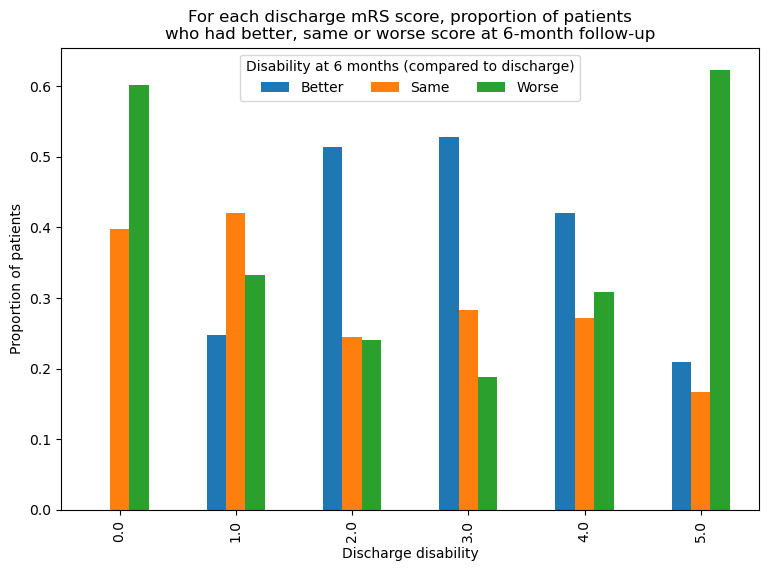

disability_6_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0
discharge_disability,,,,,,,
0.0,0.398364,0.347759,0.141421,0.064917,0.013801,0.002897,0.030840
1.0,0.247394,0.419754,0.177624,0.098772,0.020023,0.002580,0.033853
2.0,0.155993,0.358020,0.244961,0.153488,0.033274,0.005247,0.049016
3.0,0.075126,0.218686,0.234258,0.283568,0.080180,0.012293,0.095889
4.0,0.017105,0.073872,0.107895,0.221053,0.271617,0.079323,0.229135
5.0,0.003871,0.012776,0.010840,0.043360,0.138986,0.166473,0.623693


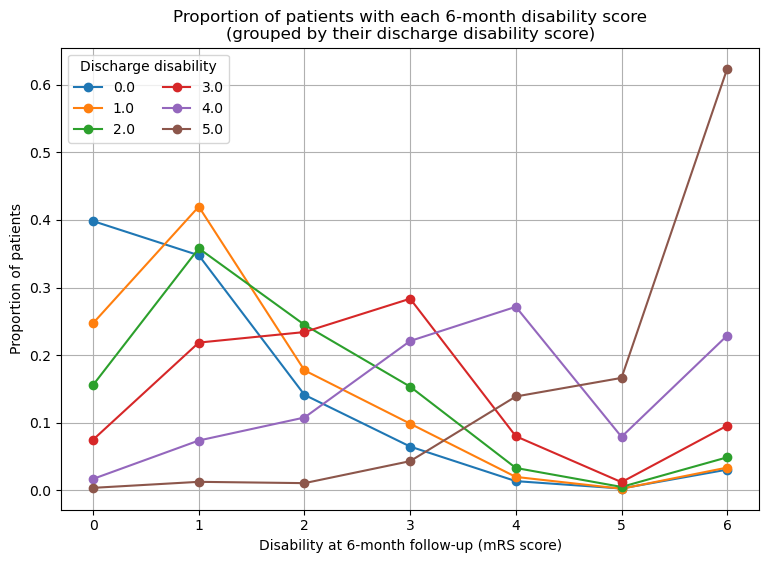

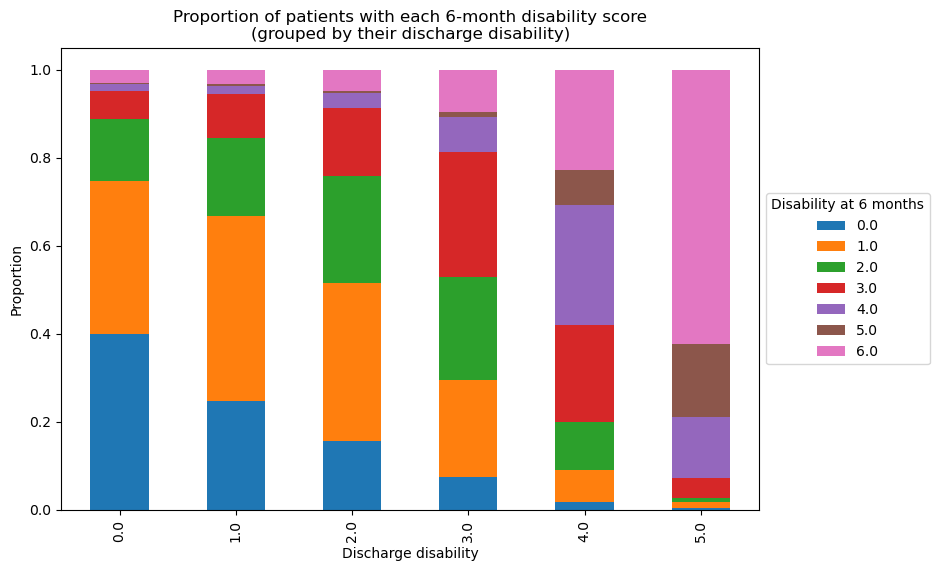

In [17]:
print('For patients with disability at discharge and 6 months')
print('who had arrived within 4 hours of known stroke onset...\n')
disability_change(data)
plot_disability_change(data)
plot_follow_up_by_discharge(data)

**EXCLUDING those who are marked as having died at 6 months**, the mean change in mRS is -0.2 (i.e. a slight improvement)

In [18]:
# Filter to patients who were alive at discharge AND follow-up
not_dead = data_alive[data_alive['disability_6_month'] != 6]

print('For patients with disability at discharge and 6 months')
print('who had arrived within 4 hours of known stroke onset...\n')
disability_change(not_dead)

For patients with disability at discharge and 6 months
who had arrived within 4 hours of known stroke onset...

From discharge to 6 months later, the mean change in
    Modified Rankin Scale score is -0.2


count    34715.000000
mean        -0.189025
std          1.260271
min         -5.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          5.000000
dtype: float64

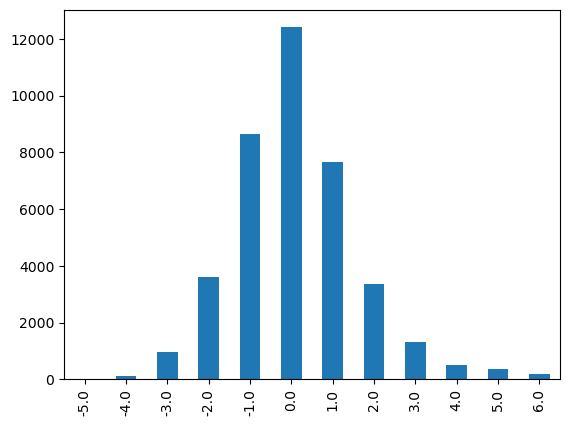

In [19]:
mrs_6m = ((data_alive['disability_6_month'] -
           data_alive['discharge_disability']).dropna())
mrs_6m.value_counts().sort_index().plot(kind='bar')
plt.show()

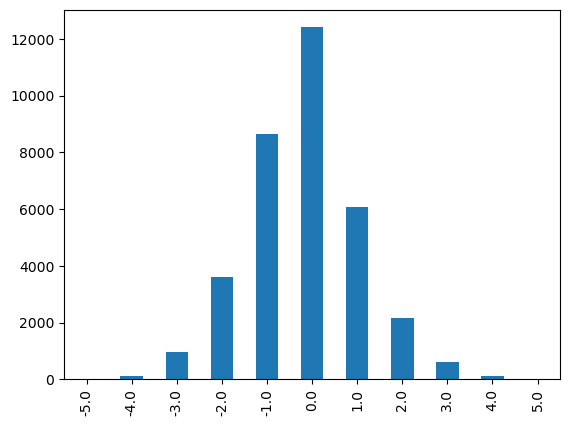

In [20]:
mrs_6m = ((not_dead['disability_6_month'] -
           not_dead['discharge_disability']).dropna())
mrs_6m.value_counts().sort_index().plot(kind='bar')
plt.show()

In [21]:
# print('For all patients with scores at both times...\n')
# disability_change(data_full)
# plot_disability_change(data_full)
# plot_follow_up_by_discharge(data_full)

## Regression (change in disability)

Multiple linear regression model, with estimation using ordinary least squares (OLS).

Caveat:
* Data is not missing at random
* mRS score is ordinal scale

### Dataset

The dataset is patients who arrived within 4 hours of known onset, and who have complete data at each disability timepoint, as well as for stroke severity, age and whether thrombolysed.

In those model, we are predicting change in disability from discharge to six month follow up.

In [22]:
# Extract relevant columns and drop rows with NA
reg_df = data[['prior_disability', 'stroke_severity', 'age',
               'thrombolysis', 'discharge_disability',
               'disability_6_month']].dropna().reset_index()
display(reg_df.shape)

# Define predictor and response variables
X = reg_df[['prior_disability', 'stroke_severity', 'age',
            'thrombolysis', 'discharge_disability']]
y = reg_df['disability_6_month'] - reg_df['discharge_disability']

(39167, 7)

### Transform data, fit model, and collect evaluation metrics

In [23]:
def standardise_data(X_train, X_test):
    '''
    Put features on a similar scale through standardisation.
    Just transforms features (not response/target variable).
    Invovles subtracting mean and dividing by standard deviation (SD)
    of each feature, so data have mean of 0 and SD of 1.
    Test data is standardised on training data mean and SD.
    '''

    # Set up scaling object and fit on training data
    sc = StandardScaler()
    sc.fit(X_train)

    # Apply scaling to training and test data
    train_std = sc.transform(X_train)
    test_std = sc.transform(X_test)

    return train_std, test_std

In [24]:
def run_regression(standardise):
    '''
    Run regression with 5-fold cross-validation
    Can choose whether to standardise input variables or not
    Returns MAE, MSE, RMSE, R2, adjusted R2, feature weights and residuals
    standardise: True or False
    '''
    # Set up to create five training/test data splits
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create empty dictionary to store results
    # (defaultdict so don't have to pre-define keys)
    reg_results = defaultdict(list)

    # Use loop to test model on those five different splits
    for train_row, test_row in kfold.split(X):
        # Split into training and test data
        X_train, X_test = X.iloc[train_row], X.iloc[test_row]
        y_train, y_test = y[train_row], y[test_row]

        if standardise:
            # Standardise X data
            X_train, X_test = standardise_data(X_train, X_test)

        # Set up and fit multiple linear regression
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Get feature weights
        reg_results['feature_weights'].append(model.coef_)

        # Predict y values using the x test values
        y_test_pred = model.predict(X_test)

        # Find residuals (difference between prediction and actual)
        resid = pd.DataFrame({'actual': y_test,
                              'pred': y_test_pred})
        resid['residuals'] = abs(resid['actual']) - abs(resid['pred'])
        reg_results['residuals'].append(resid)

        # Use predictions to calculate evaluation metrics
        reg_results['mae'].append(mean_absolute_error(y_test, y_test_pred))
        mse = mean_squared_error(y_test, y_test_pred)
        reg_results['mse'].append(mse)
        reg_results['rmse'].append(np.sqrt(mse))
        reg_results['r2'].append(r2_score(y_test, y_test_pred))
        adjusted_r2 = (1 -
                       (1 - model.score(X_train, y_train)) *
                       (len(y_train)-1) /
                       (len(y_train)-X_train.shape[1]-1))
        reg_results['adjusted_r2'].append(adjusted_r2)

    return (reg_results)

In [25]:
# Run with X variables standardised
reg_results = run_regression(standardise=True)

# Run without standardisation
reg_results_non_std = run_regression(standardise=False)

### Review results

In [26]:
def show_regression_results(results):
    '''
    Summarise results from regression, based on results dictionary input
    '''
    # Table of coefficients (as is, and absolute)
    coef = pd.DataFrame(results['feature_weights'], columns=X.columns)
    mean_coef = pd.DataFrame({'coef': coef.mean(),
                              'coef_abs': abs(coef.mean())})
    mean_coef_sort = mean_coef.sort_values(by='coef_abs', ascending=False)
    display(mean_coef_sort)

    # Plot of feature weights
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(mean_coef_sort.index, mean_coef_sort['coef'])
    ax.set_xlabel('Feature')
    ax.set_ylabel('Coefficient')
    plt.xticks(rotation=45)
    plt.show()

    # Metrics
    print(f'''
          Average MAE: {np.mean(results['mae']):.9f}
          Average RMSE: {np.mean(results['rmse']):.9f}
          Average R-squared: {np.mean(results['r2']):.9f}
          Average adjusted R-squared: {np.mean(results['adjusted_r2']):.9f}''')

#### Standardised results

**Understanding outcome score**

Outcome is change in disability score between discharge and six-month follow-up (disability_6_month - discharge_disability). **A negative result means that score improved.** A positive result means that the score worsened.

*Example: Patient sees improvement. They have mRS 3 at discharge and mRS 2 at 6-month. Their outcome would be negative, as score has gone down (2 - 3 = -1).*

**Interpreting the coefficients**

These are standardised - they are in units of standard deviation - and hence you can compare the relative importance of each variable, as they are on the same scale. Standardised coefficients reflect the change in outcome (in terms of standard deviation) for every increase of one standard deviation in the predictor.

* **Discharge disability** and **thrombolysis** have negative coefficients. This means that having a higher discharge disability, and receiving thrombolysis, are associated with an **improvement** in disability between discharge and follow-up (a negative change in score).
* **Prior disability**, **stroke severity** and **age** have positive coefficients. This means that having a higher prior disability, higher stroke severity, and older age, are associated with a **worsening** in disability between discharge and follow-up (a positive change in score).
* Discharge disability largest, so greatest relative importance.

**Note:** If you have a higher discharge disability, you have **more scope to improve** (e.g. mRS 5 can go down to mRS 1, but mRS 1 can change by a max of 1 to mRS 0). Hence, it is essentially an artefact of the scale and the scope to change. This analysis may therefore feel unhelpful - but should consider that it is still helpful in thinking through what is going on in the data.

**Interpreting the metrics**
* **MAE**: Mean absolute error. Calculation is to find average of the residuals (which themselves are the difference between actual and predicted values). Lower value implies higher accuracy. Difficult to interpret as generally about comparing accuracy between models and depends on scale in dataset.
* **RMSE**: Square root of variance of residuals. Average distance between predicted and observed values. It shows absolute fit of model. Likewise hard to interpret without comparison.
* **R-squared**: Relatived fit of model. Also known as coefficient of multiple determination. Percentage of variance explained (variance explained by the model over the total variance). R squared of 17% means that model explains 17% of variation in response variable around the mean.
* **Adjusted R-squared:** Important in multiple regression. Issue with R-squared is that it increases with every predictor added to the model, so you may think you have a better fit, the more terms you add, which is misleading. Adjusted R-squared is adjusted for the number of independent variables in the model. It will increase if useful variables are added to the model and decrease if useless variables are added.

,coef,coef_abs
discharge_disability,-0.754259,0.754259
prior_disability,0.420169,0.420169
stroke_severity,0.326516,0.326516
age,0.193207,0.193207
thrombolysis,-0.132672,0.132672


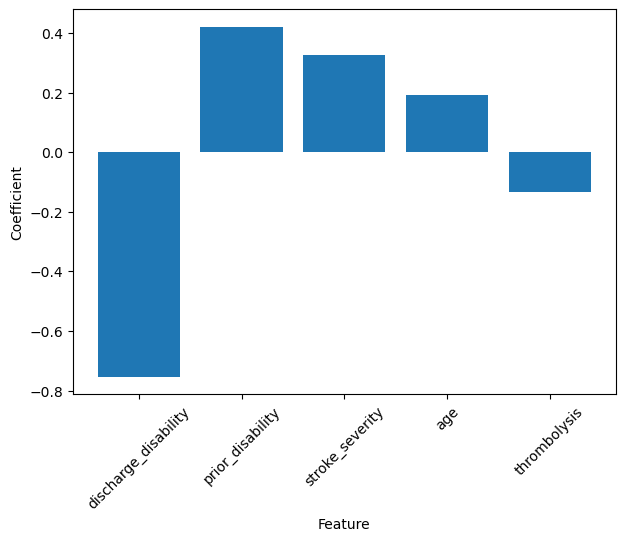


          Average MAE: 1.048270786
          Average RMSE: 1.375681834
          Average R-squared: 0.177001223
          Average adjusted R-squared: 0.177233764


In [27]:
# Standardised prior to regression
show_regression_results(reg_results)

#### Unstandardised results

**Interpreting the coefficients**

These variables were not standardised, so the coefficients are in their original units.  The coefficients represent the change in the outcome variable, for every one unit increase in the predictor, when the value of all other predictors is held constant. It shows that the relationship remains even when you control for other variables. It does not provide evidence for/against a causal relationship. The **direction of relationships is the same** as in the standardised regression.

Examples:
* **Thrombolysis** coefficient -0.28 means that, on average, if you had thrombolysis, you have a 0.28 improvement in mRS score between discharge and follow-up (association not causal, and of people who were followed up)
* **Discharge disability** coefficient -0.51 means having a one mRS score higher discharge disability associates with an improvement of 0.51 in mRS score between discharge and follow-up

**Interpreting the metrics**

These are the same as the metrics when unstandardised variables were used. Why is that?
* Is it because scikit learn standardise for you anyway? No, they don't do this, we checked the documentation and model code.
* Is it as this is a large dataset?
* Is it as there isn't huge variation in scales between the variables?

,coef,coef_abs
discharge_disability,-0.513378,0.513378
prior_disability,0.328601,0.328601
thrombolysis,-0.284410,0.284410
stroke_severity,0.050239,0.050239
age,0.014920,0.014920


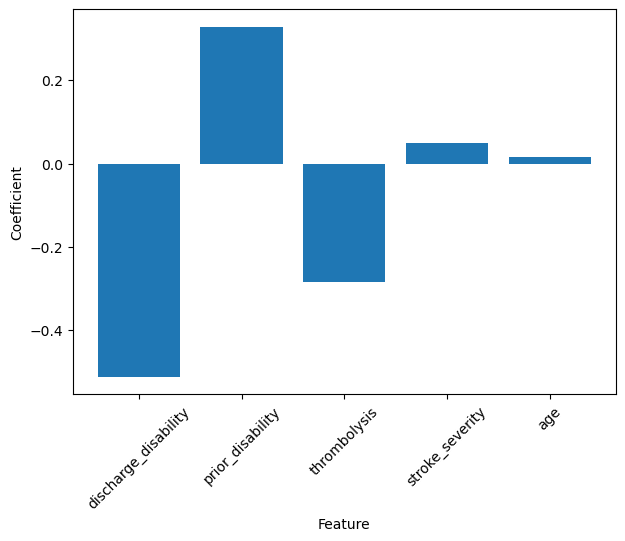


          Average MAE: 1.048270786
          Average RMSE: 1.375681834
          Average R-squared: 0.177001223
          Average adjusted R-squared: 0.177233764


In [28]:
# Did not standardise prior to regression
show_regression_results(reg_results_non_std)

### Assumptions

In [29]:
# Look at relationship between actual and predicted values
def test_linear(df):
    '''
    Test assumption of linearity.
    df is dataframe containing columns with predicted and actual
    values of the response variable.
    '''
    # Plot actual and predicted values
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(df['actual'], df['pred'])
    ax.set_xlabel('Actual value')
    ax.set_ylabel('Predicted value')

    # Add diagonal line (based on overall min and max)
    line_coords = (df.min().min(), df.max().max())
    ax.plot(line_coords, line_coords, ls='--')

    plt.show()


def test_assumptions(X, reg_results):
    '''
    Tests assumptions of multiple linear regression
    X: dataframe where each column is a predictor variable
    reg_results: dictionary output by regression
    '''
    # Test for linear relationship between each predictor and outcome
    print('Linearity - look at relationship between each predictor and ' +
          'outcome - or look at\nrelationship between predicted and actual ' +
          'values (linearity indicated by even spread around diagnoal line)')

    # Look at linear relationship between each predictor and outcome
    fig, ax = plt.subplots(nrows=1, ncols=len(X.columns), figsize=(15, 3))
    for i in np.arange(len(X.columns)):
        ax[i].scatter(X.iloc[:, i], y)
        ax[i].set_xlabel(X.columns[i])
        ax[i].set_ylabel('Change in disability from\ndischarge to followup')
    fig.tight_layout()
    plt.show()

    # Just plot from first train/test split
    test_linear(reg_results['residuals'][0])

    # Look at averages (if scatter not meaningful for linearity)
    fig, ax = plt.subplots(nrows=1, ncols=len(X.columns), figsize=(15, 3))
    for i in np.arange(len(X.columns)):
        averages = X.groupby(y)[X.columns[i]].mean()
        averages.plot(marker='.', ax=ax[i])
        ax[i].set_xlabel('Change in mRS from discharge\n' +
                         'to 6-month follow-up')
        ax[i].set_ylabel(X.columns[i])
    fig.tight_layout()
    plt.show()

    # Test for normally distributed residuals
    print('Normally distributed residuals:')
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(reg_results['residuals'][0]['residuals'],
            edgecolor='black', bins=20)
    plt.show()

    # Test for independent observations (just review manually)
    print('Independent observations: review manually\n')

    # Test for homoscedasticity
    print('Homoscedasticity - should be no patterns in distributions of' +
          'residuals - i.e. the size of error\nshould not relate to' +
          'the value of the outcome variable):')
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.scatter(reg_results['residuals'][0].index,
               reg_results['residuals'][0].residuals,
               s=0.5)
    plt.show()

    # Test for multicolinearity
    print('Multicolinearity - if there is multicolinearity present, it ' +
          'will result in less precise estimates of individual\n' +
          'regression parameters (difficult to decide precisely what' +
          'each variable contributes) (unstable estimates, may vary\n' +
          'alot with addition or removal of data points) (larger' +
          'sample sizes can better handle multicolinearity)')
    display(round(X.corr(), 2))

    # Create figure object
    fig, ax = plt.subplots(figsize=(4, 4))

    # Set colours
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        '', ['red', 'white', 'blue'])
    norm = matplotlib.colors.TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)

    # Create heatmap
    heatmap = ax.imshow(X.corr(), cmap=cmap, norm=norm)

    # Add legend for colours
    fig.colorbar(heatmap)

    # Show plot
    plt.show()

**Observations:**
* Linearity - not really
* Normally distributed residuals - no (slight left skew)
* Independent observations - yes (as each row is different patient)
* Homoscedasticity - yes, appears so
* Multicolinearity - alright, max is 0.5, so doesn't appear to be problematic colinearity

Linearity - look at relationship between each predictor and outcome - or look at
relationship between predicted and actual values (linearity indicated by even spread around diagnoal line)


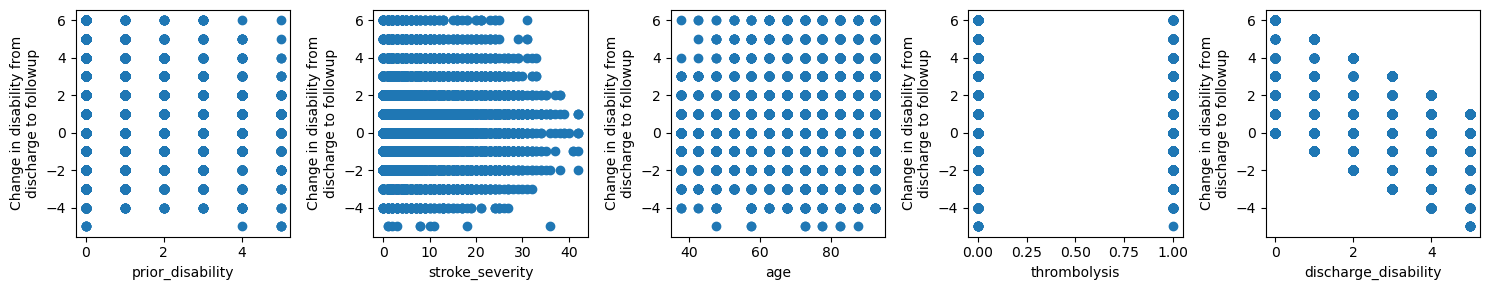

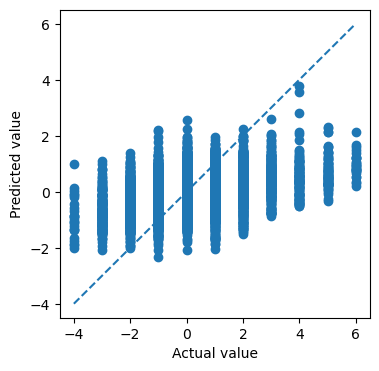

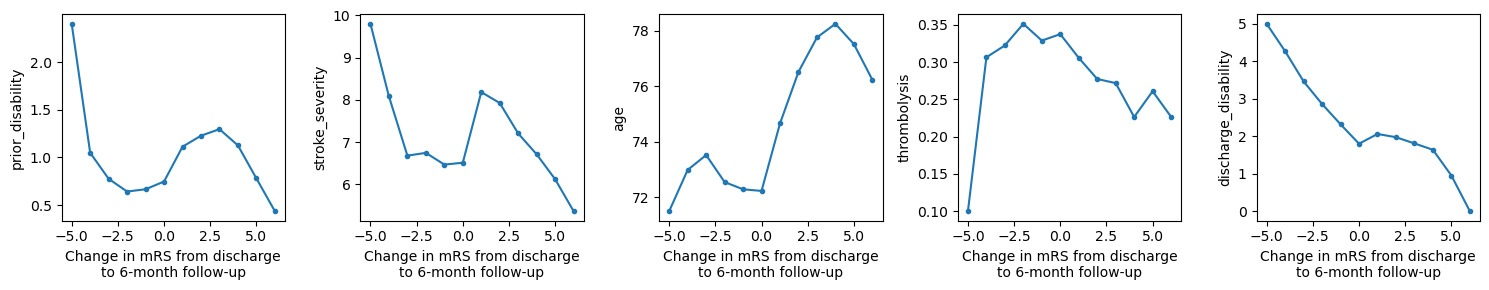

Normally distributed residuals:


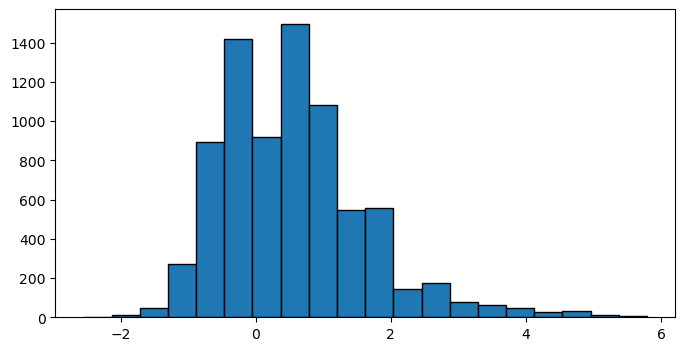

Independent observations: review manually

Homoscedasticity - should be no patterns in distributions ofresiduals - i.e. the size of error
should not relate tothe value of the outcome variable):


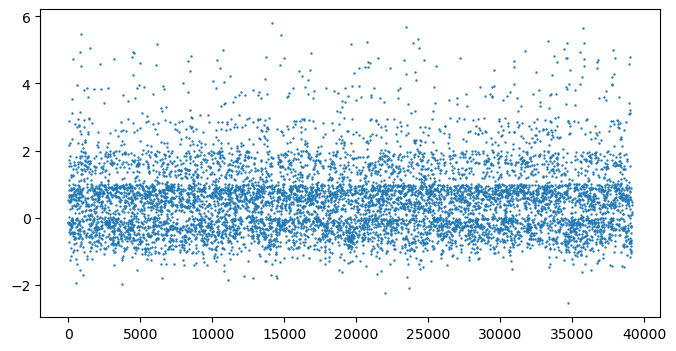

Multicolinearity - if there is multicolinearity present, it will result in less precise estimates of individual
regression parameters (difficult to decide precisely whateach variable contributes) (unstable estimates, may vary
alot with addition or removal of data points) (largersample sizes can better handle multicolinearity)


,prior_disability,stroke_severity,age,thrombolysis,discharge_disability
prior_disability,1.00,0.18,0.37,-0.14,0.50
stroke_severity,0.18,1.00,0.08,0.30,0.40
age,0.37,0.08,1.00,-0.08,0.29
thrombolysis,-0.14,0.30,-0.08,1.00,-0.05
discharge_disability,0.50,0.40,0.29,-0.05,1.00


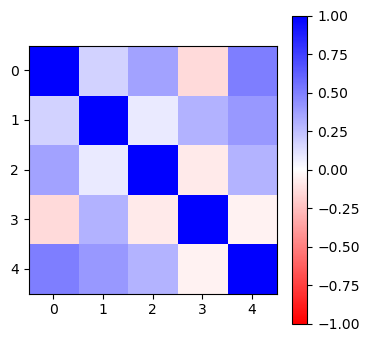

In [30]:
test_assumptions(X, reg_results)

## Regression (whether have follow-up appointment)

Multiple logistic regression model.

### Dataset

The dataset is patients who arrived within 4 hours of known onset, and who have complete data data for discharge disability, stroke severity, age and whether thrombolysed. They can have incomplete data for 6-month follow-up (as that is what we are predicting).

In [31]:
# Extract relevant columns, resetting index else set on slice
reg_df = data[['prior_disability', 'stroke_severity', 'age',
               'thrombolysis', 'discharge_disability']].reset_index(drop=True)

# Create column of whether had follow-up
reg_df['6_month_complete'] = (
    data['disability_6_month'].isnull().map({False: 1, True: 0}))
display(reg_df['6_month_complete'].value_counts(normalize=True))

# Drop NA
reg_df = reg_df.dropna().reset_index(drop=True)
display(reg_df.shape)

# Define predictor and response variables
X = reg_df[['prior_disability', 'stroke_severity', 'age',
            'thrombolysis', 'discharge_disability']]
y = reg_df['6_month_complete']

0    0.714149
1    0.285851
Name: 6_month_complete, dtype: float64

(136012, 6)

In [32]:
def logistic_regression(standardise):
    '''
    Run logistic regression with 5-fold cross-validation
    Can choose whether to standardise input variables or not
    Returns MAE, MSE, RMSE, R2, adjusted R2, feature weights and residuals
    '''
    # Set up to create five training/test data splits
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create empty dictionary to store results
    # (defaultdict so don't have to pre-define keys)
    reg_results = defaultdict(list)

    # Use loop to test model on those five different splits
    for train_row, test_row in kfold.split(X):
        # Split into training and test data
        X_train, X_test = X.iloc[train_row], X.iloc[test_row]
        y_train, y_test = y[train_row], y[test_row]

        if standardise:
            # Standardise X data
            X_train, X_test = standardise_data(X_train, X_test)

        # Set up and fit multiple linear regression
        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Get feature weights
        reg_results['feature_weights'].append(model.coef_)

        # Get accuracy
        reg_results['accuracy'] = model.score(X_test, y_test)

        # Get confusion matrix
        predictions = model.predict(X_test)
        reg_results['confusion'] = confusion_matrix(y_test, predictions)

    return (reg_results)

Predicts everything to not be a follow-up as that is majority in dataset.

In [33]:
logistic_regression(True)

defaultdict(list,
            {'feature_weights': [array([[ 0.05131654, -0.11633305,  0.07940351,  0.0847804 , -0.51825672]]),
              array([[ 0.04086695, -0.1211715 ,  0.07621306,  0.08606179, -0.50626478]]),
              array([[ 0.05181745, -0.11553565,  0.07634126,  0.08754673, -0.51495727]]),
              array([[ 0.05501441, -0.11034361,  0.07623767,  0.08122667, -0.51882853]]),
              array([[ 0.05058295, -0.11738322,  0.07586085,  0.08498964, -0.51801585]])],
             'accuracy': 0.7101316079700022,
             'confusion': array([[19309,    16],
                    [ 7869,     8]])})